# Pytorch

In [ ]:
!pip install transformers
!pip install diffusers

In [ ]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms


## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def prompt_2_img(prompts, neg_prompts=None, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding negative prompt condition
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Saving intermediate images
        if save_int:
            if not os.path.exists(f'./steps'): os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')

    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

<ipython-input-4-61c6cbd973d9>:102: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-36-9ec03913e466>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((new_width, new_height), Image.ANTIALIAS)


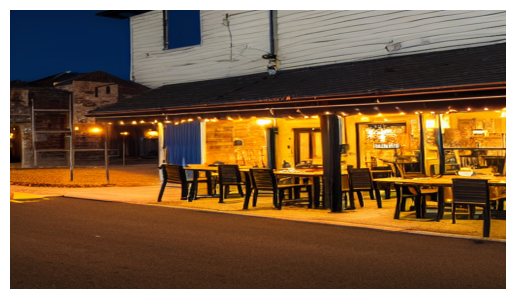

In [ ]:
images = prompt_2_img(prompts=" photograpy,At a cafe on a cool summer night,landscape, 8k uhd"
                      ,neg_prompts="finger, toe, body, hair, face, eyes, nose, ears,lip, legs, arms, hands, feet, girl, boy, people"
                      ,steps=50, save_int=False)
image = images[0]
new_width, new_height = (1280, 720)
image = image.resize((new_width, new_height), Image.ANTIALIAS)
plt.imshow(image)
plt.axis('off')
plt.show()
